In [1]:
import bisect
from collections import *
import math
import numpy as np

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

<br>

# Motivation: compact and useful representations
---

Say we have a tree or a graph as input, that represents some kind of hierarchy or interconnections we care about. We are interested in dealing with this graph in a particular manner. For instance, we care a lot about the shortest distance between every elements, and we to be able to retrieve this information really fast:

* We could keep the all graph in memory and recompute the shortest path each time, but this is not really fast.
* On the opposite of the spectrum, we could precompute (or cache) the distances between every pairs of elements.

An alternative approach, is to try to find a representation that is both **compact and keeps most of the information** about the distances intact. This representation is what we call **embedding** for it embedds the graph into a (usually lower dimensional) representation.

[[0. 1. 2. 3. 4. 4. 6. 7. 5. 6.]
 [1. 0. 1. 2. 3. 3. 5. 6. 4. 5.]
 [2. 1. 0. 1. 2. 2. 4. 5. 3. 4.]
 [3. 2. 1. 0. 1. 1. 3. 4. 2. 3.]
 [4. 3. 2. 1. 0. 2. 4. 5. 3. 4.]
 [4. 3. 2. 1. 2. 0. 2. 3. 1. 2.]
 [6. 5. 4. 3. 4. 2. 0. 1. 1. 2.]
 [7. 6. 5. 4. 5. 3. 1. 0. 2. 3.]
 [5. 4. 3. 2. 3. 1. 1. 2. 0. 1.]
 [6. 5. 4. 3. 4. 2. 2. 3. 1. 0.]]


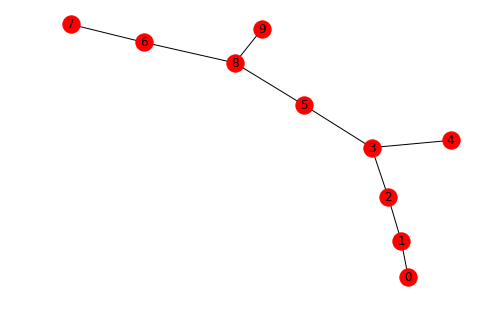

In [3]:
class Node:
    def __init__(self, value: int, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

        
def to_graph(root: Node, directed: bool):
    g = defaultdict(list)
    to_visit = [root]
    while to_visit:
        node = to_visit.pop()
        for child in node.left, node.right:
            if child:
                g[node.value].append(child.value)
                if not directed:
                    g[child.value].append(node.value)
                to_visit.append(child)
    return g

    
def draw_tree(root: Node):
    g = nx.Graph()
    for a, bs in to_graph(root, directed=True).items():
        for b in bs:
            g.add_edge(a, b)
    nx.draw(g, with_labels=True)
    

def all_pairs_shortest_paths(root: Node):
    g = to_graph(root, directed=False)
    N = len(g)
    pairs = np.full(shape=(N, N), fill_value=np.inf)
    for i in range(N):
        pairs[i][i] = 0
        for j in g[i]:
            pairs[i][j] = 1
    for k in range(N):
        for i in range(N):
            for j in range(N):
                pairs[i][j] = min(pairs[i][j], pairs[i][k] + pairs[k][j])
    return pairs
    
    
        
"""
Sample tree
"""

root = Node(5)
root.left = Node(3, left=Node(2, left=Node(1, left=Node(0))), right=Node(4))
root.right = Node(8, left=Node(6, right=Node(7)), right=Node(9))
draw_tree(root)

distances = all_pairs_shortest_paths(root)
print(distances)

Final loss: 1.5042039262252729


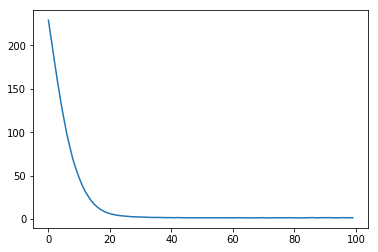

In [4]:
class GraphModel(nn.Module):
    def __init__(self, nb_embedding: int, embedding_size: int):
        super().__init__()
        self.embedding = nn.Embedding(nb_embedding, embedding_size)
    
    def forward(self, xs, ys):
        diffs = self.embedding(ys) - self.embedding(xs)
        return torch.norm(diffs, dim=-1)
    

"""
Creating the dataset
"""
    
N = len(distances)
xs = []
ys = []
ds = []
for i in range(N):
    for j in range(i, N):
        xs.append(i)
        ys.append(j)
        ds.append(distances[i][j])

training_set = data.TensorDataset(
    torch.LongTensor(xs),
    torch.LongTensor(ys),
    torch.FloatTensor(ds))
loader = data.DataLoader(training_set, shuffle=True)


"""
Training the model
"""

model = GraphModel(N, 3)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-2)
criterion = nn.MSELoss()

losses = []
for _ in range(100):
    epoch_loss = 0.
    for x, y, d in loader:
        got = model(x, y)
        loss = criterion(got, d)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
print("Final loss:", losses[-1])
    
plt.plot(losses)
plt.show()

Distances in embedding:
[[0. 1. 2. 3. 4. 4. 6. 7. 5. 6.]
 [1. 0. 1. 2. 3. 3. 5. 6. 4. 5.]
 [2. 1. 0. 1. 2. 2. 4. 5. 3. 4.]
 [3. 2. 1. 0. 1. 1. 3. 4. 2. 3.]
 [4. 3. 2. 1. 0. 2. 4. 5. 3. 4.]
 [4. 3. 2. 1. 2. 0. 2. 3. 1. 2.]
 [6. 5. 4. 3. 4. 2. 0. 1. 1. 2.]
 [7. 6. 5. 4. 5. 3. 1. 0. 2. 3.]
 [5. 4. 3. 2. 3. 1. 1. 2. 0. 1.]
 [6. 5. 4. 3. 4. 2. 2. 3. 1. 0.]]
Distances in graph:
[[0. 1. 2. 3. 4. 4. 6. 7. 5. 6.]
 [1. 0. 1. 2. 3. 3. 5. 6. 4. 5.]
 [2. 1. 0. 1. 2. 2. 4. 5. 3. 4.]
 [3. 2. 1. 0. 1. 1. 3. 4. 2. 3.]
 [4. 3. 2. 1. 0. 2. 4. 5. 3. 4.]
 [4. 3. 2. 1. 2. 0. 2. 3. 1. 2.]
 [6. 5. 4. 3. 4. 2. 0. 1. 1. 2.]
 [7. 6. 5. 4. 5. 3. 1. 0. 2. 3.]
 [5. 4. 3. 2. 3. 1. 1. 2. 0. 1.]
 [6. 5. 4. 3. 4. 2. 2. 3. 1. 0.]]


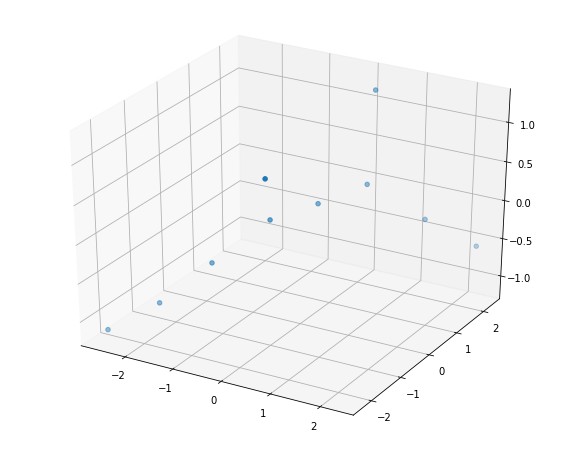

In [9]:
embeddings = model.embedding.weight.detach().numpy()
got_distances = np.zeros(shape=(N, N))
for i in range(N):
    for j in range(N):
        got_distances[i][j] = np.linalg.norm(embeddings[i] - embeddings[j])
        

print("Distances in embedding:")
print(np.round(got_distances, decimals=0))

print("Distances in graph:")
print(distances)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings[:,0], embeddings[:,1], embeddings[:,2])
plt.show()

<br>

# Knowledge graphs => Embeddings
---

The technique shown above is generally useful for other examples in which a **graph structure** is present (although it might not always be obvious).

<br>

### Word embeddings

The main place in which embeddings are popular at this time is for **Natural Language Processing** (NLP). Here, embeddings are used to represent a word as a vector, so that this vector can be proceeded by a Machine Learning algorithm.

Indeed, words cannot be fed as text to most algorithms, and one should be very careful when representing words as numbers: **any order in the number will be used by a Neural Net and should better represent some real relationship**.

* close numbers means close meaning for a machine
* several notions of "closeness" means several dimension

Word embeddings are typically trained by building a kind of knowledge graph with unsupervised learning, by feeding a lot of text:

* We try to predict a the word in a middle of 10 words for instance (bag of words)
* We try to predict the words surrounding a word (skip-gram)
* We try to predict the next word after 5 words (language model)

This will have the tendency to represent the close-to relations in the embeddings. Words that are close semantically will be close in their representation (short distance). Relations such as "is-capital-of" will be represented by constant vectors, and such.

In [32]:
from annoy import AnnoyIndex
import torchtext

fast_text = torchtext.vocab.FastText(max_vectors=10_000)
index = AnnoyIndex(fast_text.vectors.shape[1])
for i in range(fast_text.vectors.shape[0]):
    index.add_item(i, fast_text.vectors[i])
index.build(5)

def show_neighbors(word):
    i = fast_text.stoi.get(word)
    indices = index.get_nns_by_vector(fast_text.vectors[i], n=10)
    return [fast_text.itos[i] for i in indices]

In [33]:
show_neighbors('car')

['car',
 'cars',
 'truck',
 'vehicle',
 'driver',
 'driving',
 'vehicles',
 'motorcycle',
 'chassis',
 'bmw']

<br>

### Recommendation systems

Recommending friends or films can be approached the same way. As for most graph problems, the key is not so much to know that most problems can be seen as graph problems, but to actually **construct the graph that you care about**.

For instance, for films, we could try to encode the likes as a **bipartite graph** (films nodes, linked to person nodes) and that could allow us to have some connectivity metrics between persons: how many films do you have in common that you like, vs those not in common. This could define a metric: the closer the are, the more film you have in common.

This in turn can be used to help find films that some similar person of you liked, but you did not watched for now.

<br>

# Other examples
---

* similar faces / images (example MNIST)
* similar tasted in films
* similar words